In [1]:
import torch
import numpy as np
import gymnasium as gym

import sys
sys.path.append('../../..')
from tools.trainer import Trainer
from tools.logger import Logger
from environments.hockey_wrapper import HockeyWrapper
from TD3 import TD3Agent
import laserhockey.hockey_env as h_env

In [2]:
env_string = "Hockey"

In [3]:
if env_string == "Hockey":
    env = HockeyWrapper(mode="normal", opponent="weak")
else:
    env = gym.make(env_string)

In [4]:
agent = TD3Agent(env.observation_space, env.action_space)
trainer = Trainer()

In [5]:
player = h_env.BasicOpponent(weak=False)

In [6]:
ep_rewards = trainer.train(env, agent, n_episodes=30000, test_every=100, noise=0.2, player=player)

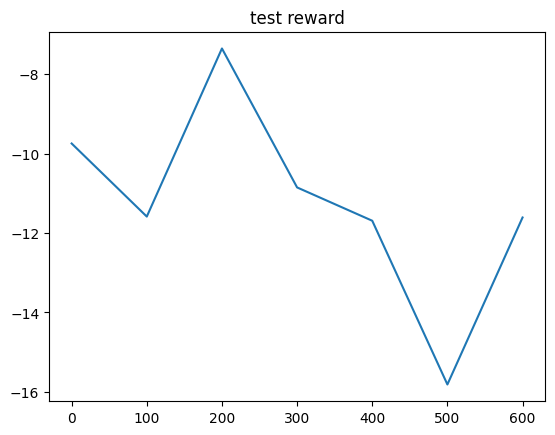

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

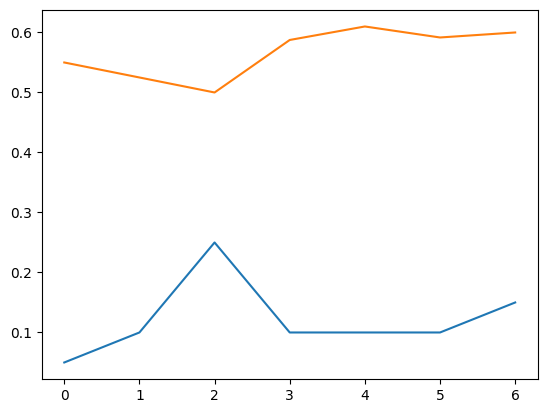

In [ ]:
trainer.logger.plot()

In [ ]:
def play(env_string, agent, n_episodes=10, noise=0):
    if env_string == 'Hockey':
        env = HockeyWrapper(mode='normal', opponent='weak')
        render = True
    else:
        env = gym.make(env_string, render_mode='human')
        render = False
    player = h_env.BasicOpponent(weak=False)
    steps, rewards, observations, actions, results = Trainer.run(env, player, n_episodes=n_episodes, noise=noise, render=render, store_transitions=False, hockey=env_string=='Hockey')
    env.close()
    return steps, rewards, observations, actions, results

In [ ]:
steps, rewards, observations, actions, results = play(env_string, agent, n_episodes=5, noise=0)
print(np.mean(rewards))
print(np.mean(results==1), np.mean(results==0), np.mean(results==-1))

2.965634386152308
0.6 0.4 0.0


In [ ]:
trainer.logger.save("logs/pendulum_td3.npy")

In [ ]:
# torch.save(agent.state(), 'checkpoint_hockey.pth')

In [ ]:
# agent_state = torch.load('checkpoint_hockey.pth')
# agent.restore_state(agent_state)